<figure>
  <IMG SRC="img/logo_ufaz.png" WIDTH=100 ALIGN="right">
</figure>

# Lab 6 : Processing of a signal from beginning to end
*Signal Processing in Geosciences / C. Jodry / Oct. 2020* 

---------

In [2]:
import numpy as np
import math
from scipy import signal
from numpy import fft
import matplotlib.pyplot as plt
% matplotlib inline
from IPython.display import Audio, display

## 1. SNRM signal

The magnetic resonance phenomena is based on the interaction between an induced EM field and the proton of hydrogen in water molecules. What is measured is the EM relaxation emitted by the proton after the induced field is shut off. This relaxation is of the form:

$ e(t) = E_0.sin(2\pi f_0t).e^{(\frac{-t}{T_e})}$

With $E_0$ being the initial amplitude, $f_0$ the Larmor Frequency (precession of  the proton's magnetic moment, https://en.wikipedia.org/wiki/Larmor_precession) and $T_e$ the time decay constant.

The recording device has a sampling frequency of 19200Hz.

The file `Griesh_RX1&3_stk6.txt` contains raw EM noise recorded near Strasbourg (France) by a NumisPoly at a sampling frequency of 19200Hz. The data serie contains a synchroneous noise recording of Rx1, the principal loop and Rx3, the reference loop (colomun 2 and 3). The first column contains a noise recording on Rx1 a few ms ealier than the ones in column 2 and 3.

> To do :
* Import the noise recording and make three vector correspondingto each column of the data series (1st col noise window, 2nd col Rx1 and 3rd col Rx3)
* Create a SNMR signal e(t) of the same length as the data serie and with the following paramaters: $E_0 = 200 mV$, $f_0 =  2041.3 Hz$ and $T_e = 0.1 s$
* Combine Rx1 recording with the synthetic signal

In [3]:
#load data
#A = np.loadtxt('Data/Griesh_RX1&3_stk6.txt')
A = np.loadtxt('Data/data_gries.txt')
noise = A[:,0]
rx1 = A[:,1]
#rx2 = A[:,2]
rx2 = A[:,3]

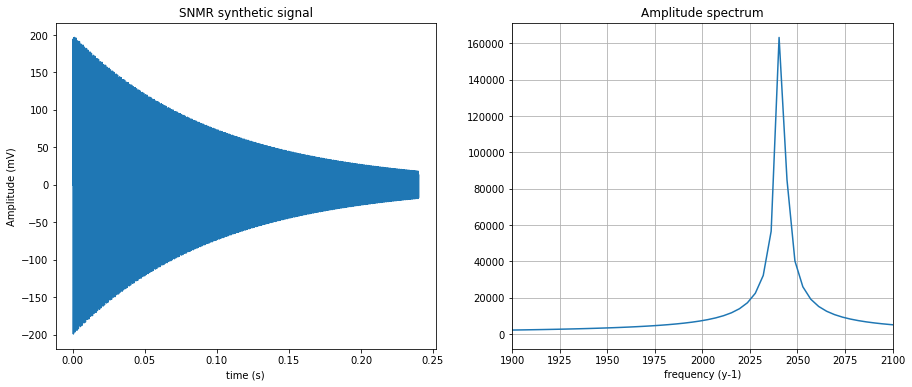

In [4]:
# Creation of SNMR signal

# parameters
Fs = 19200
f0 = 2041.3
E0 = 200
Te = 0.1
dt = 1/Fs

# Create time vector
N = len(rx1)
t = np.arange(0,N*dt,dt)

# Create signal
e = E0*np.sin(2*np.pi*f0*t)*np.exp(-t/Te)

E = fft.fft(e)
f = fft.fftfreq(N,dt)

# Plotting
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(t,e)
plt.xlabel('time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('SNMR synthetic signal')

plt.subplot(122)
plt.plot(f[0:int(N/2)],np.abs(E[0:int(N/2)]))
plt.xlabel('frequency (y-1)')
plt.title('Amplitude spectrum')
plt.xlim([1900,2100])
plt.grid()

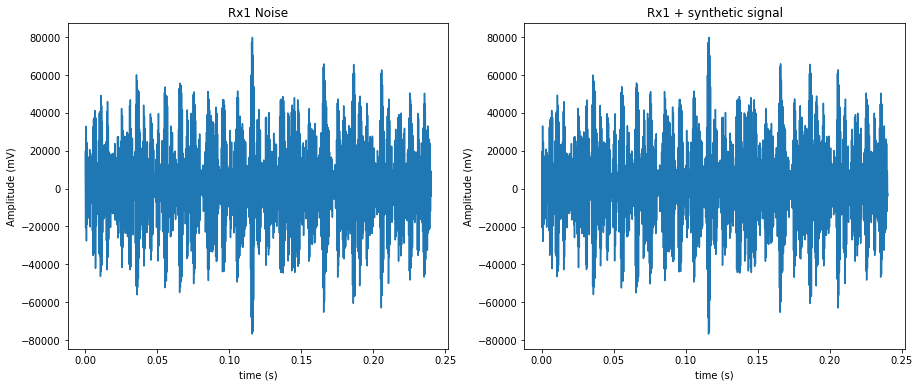

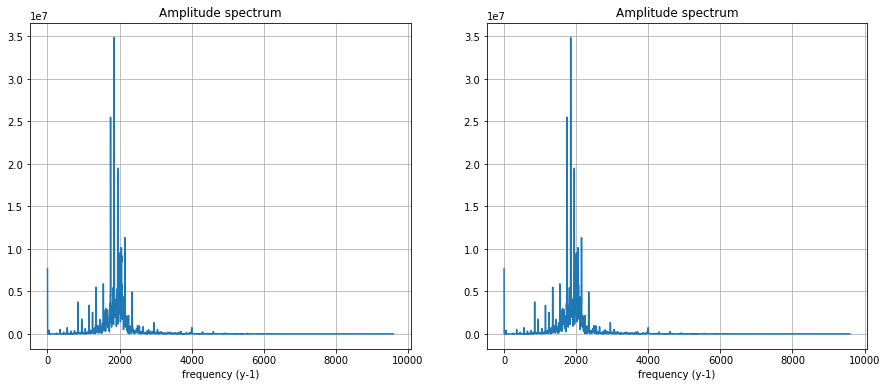

In [5]:
rx1_sig=rx1+e

RX1 = fft.fft(rx1)
RX1_sig = fft.fft(rx1_sig)


# Plotting 
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(t,rx1)
plt.xlabel('time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Rx1 Noise')

plt.subplot(122)
plt.plot(t,rx1_sig)
plt.xlabel('time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Rx1 + synthetic signal')

# Plotting 
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(f[0:int(N/2)],np.abs(RX1[0:int(N/2)]))
plt.xlabel('frequency (y-1)')
plt.title('Amplitude spectrum')
plt.grid()

plt.subplot(122)
plt.plot(f[0:int(N/2)],np.abs(RX1_sig[0:int(N/2)]))
plt.xlabel('frequency (y-1)')
plt.title('Amplitude spectrum')
plt.grid()

# 2. Processing: correlation and power spectrum

In [25]:
Corr = np.corrcoef(rx1,rx2)
print(Corr)

[[ 1.         -0.50906564]
 [-0.50906564  1.        ]]


# 3. Processing: noise removal

In SNMR, you have different types of noise:

$s(t) = e(t) + sp(t) + h(t) + r(t)$

- $sp$ are spike-like noises = induced short impulses that originate from both natural and artificial sources (e.g. lightning/thunderstorms, electrical fences, generators)
- $h$ is the harmonic noise = as in powerlines harmonics
- $r$ is the random noise = usually Gaussian distributed white noise (ambient noise)

The remaining noise can be mitigated with a pass-band filter centered on the Larmor frequency.

## 2.1 Removal of spike noise

Spikes-like noise can be rejected using an amplitude threshold, in the time domain or wavelet-domain. 

In [ ]:
ts_std(i,j,k)=std(handles.data.Pro(i).Rx(j).Signal(k).X);
handles.data.Pro(i).Rx(j).Signal(k).spiky_events=ones(size(handles.data.Pro(i).Rx(j).Signal(k).X,1),1)
i1=find( handles.data.Pro(k).Rx(ll).Signal(pp).X>handles.parameters.despiking_options.max_threshold*ts_std(k,ll,pp) );
i2=find( handles.data.Pro(k).Rx(ll).Signal(pp).X<(-handles.parameters.despiking_options.max_threshold*ts_std(k,ll,pp)) );

## 2.2 Removal of harmonics

The powerlines harmonics are sinusoids whose frequencies are integer multiples of the fundamental frequency, depending on the country power grid (50Hz in France). Their amplitude is often much stronger than natural noise. Many procedures have been implemented to remove or diminish their effect either in time or frequency domain. 
We will show two possible ways:
- The Notch filter which is based on filtering out the fondamental frequency and its harmonics
- The multichannel filter which uses a reference signal to filter out the harmonics

Notch filter

In [22]:
powerline_freq = 50
low_lim=0
high_lim=np.max(f)
print(low_lim)
print(high_lim)

min_harm=np.int(low_lim/powerline_freq)
max_harm=np.int(high_lim/powerline_freq)+1
print(max_harm)
harm=list(range(min_harm+1, max_harm+1))
print(harm)

0
9597.918022121014
192
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]


In [ ]:
for i in harm
    

Multichannel filter

## 2.3 Removal of random noise

The ambient noise is characterized as uncorrelated, broadband and Gaussian distributed white noise and may represent the majority of the noise energy. It is commonly reduced by repeated measurements and stacking methods.
the noise is suppressed by averaging all the signal records for a given pulse moment with a decrease in $1/\sqrt{N}$ where N is the number of records or stack.

> To do :
* Create the $b$ and $a$ vector for a low-pass filter at $0.1Hz$ (and order $2$) to be applied do your timeseries
* Use the function `signal.freqz` to plot the amplitude and phase spectrum of this filter
* Apply this filter to your timeseries with `signal.lfilter`
* Plot the timeseries and make a quick analysis of the impact of the filter

## 2.4 Application of a pass-band filter

> To do :
* Create the $b$ and $a$ vector for a low-pass filter at $0.1Hz$ (and order $2$) to be applied do your timeseries
* Use the function `signal.freqz` to plot the amplitude and phase spectrum of this filter
* Apply this filter to your timeseries with `signal.lfilter`
* Plot the timeseries and make a quick analysis of the impact of the filter